In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import \
     (LinearDiscriminantAnalysis as LDA,
      QuadraticDiscriminantAnalysis as QDA)
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

import tensorflow as tf
from tensorflow import keras
from keras import layers

In [2]:
import cv2
import gc
import os

from PIL import Image
from glob import glob

import warnings
warnings.filterwarnings('ignore')

# Lung Cancer Detection

# Background
Lung cancer is one of the leading causes of death among Americans above the age of 35. Currently, doctors are unable to diagnose patients who develop lung cancer with accuracy, and even when patients are diagnosed with lung cancer, there are many times when the carcinoma is detected all too late. 

State-of-the-art computer vision tools have the ability to classify an assortment of objects in the real world and identify them. With the Lung and Colon Cancer Histopathological Image dataset on Kaggle, the aim of this project is to train several models (2 classical supervised learning algorithms + 2 deep CNNs) in order to predict whether a CT scan of the lungs of patients show any indicators of the development of Lung Adenocarcinomas or Lung Squamous Cell Carcinomas. 

# Dataset
## Lung and Colon Cancer Histopathological Images
- 25,000 images of 5 classes including lung and colon cancer and healthy samples
- Images of size 768 x 768 pixels in jpeg format
- HIPAA compliant
### Lung Image Dataset
- 750 original images of lung tissue
  - 250 benign lung tissue
  - 250 lung adenocarcinomas
  - 250 lung squamous cell carcinomas
  - Augmented to 25,0000 images

Original Article

Borkowski AA, Bui MM, Thomas LB, Wilson CP, DeLand LA, Mastorides SM. Lung and Colon Cancer Histopathological Image Dataset (LC25000). arXiv:1912.12142v1 [eess.IV], 2019

## Data Preparation

In [3]:
lung_images = 'data/lung_image_sets'
classes = os.listdir(lung_images)
classes

['lung_aca', 'lung_n', 'lung_scc']

Here, lung_n equates to CT scans of patients with normal lungs, lung_aca equates to CT scans of patients with lung adenocarcinomas, and lung_scc equates to CT scans of patients with lung squamous cell carcinomas.

In [4]:
class_map = {
    'lung_n': 'Normal Lungs',
    'lung_aca': 'Lung Adenocarcinomas',
    'lung_scc': 'Lung Squamous Cell Carcinomas'
}

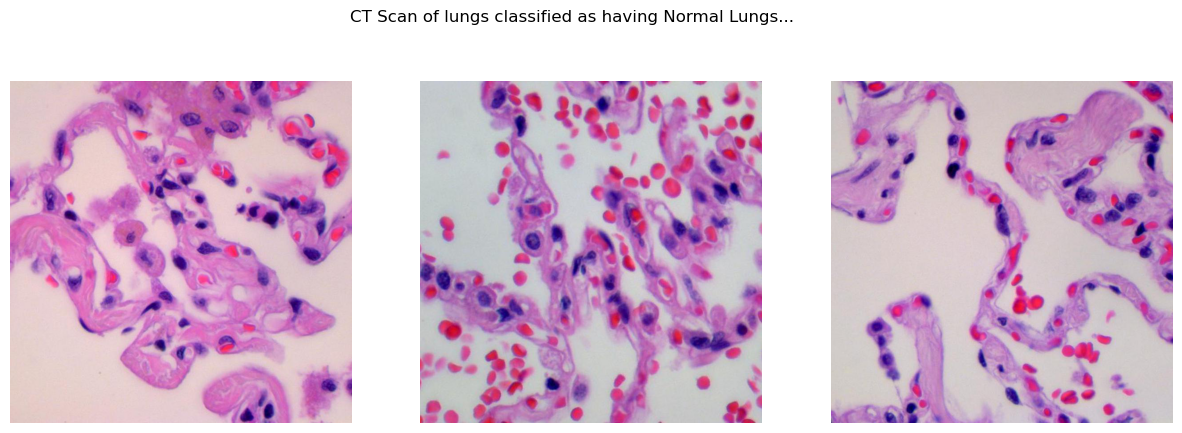

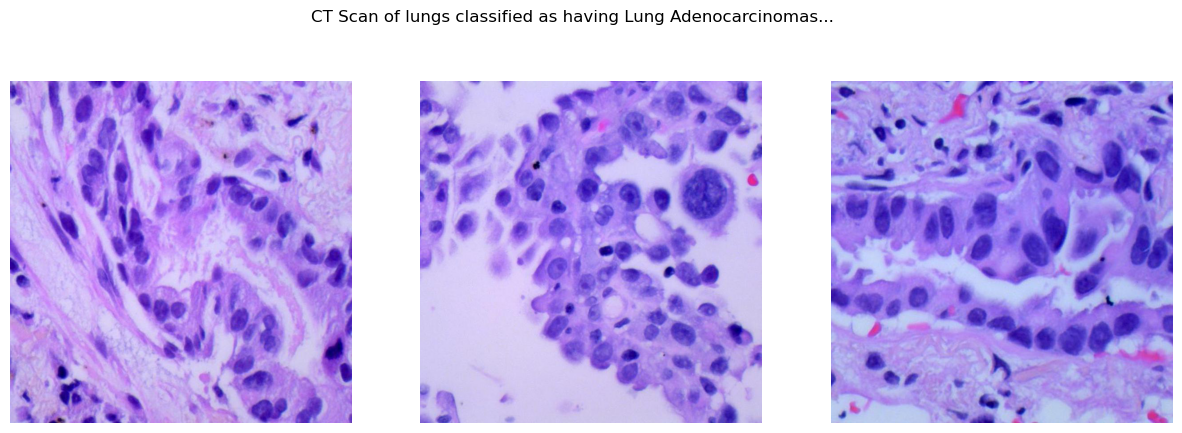

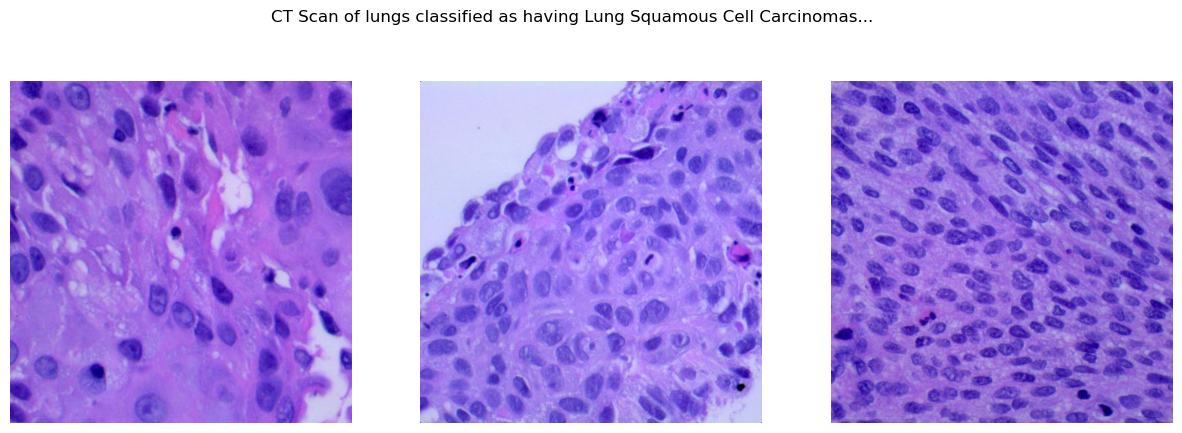

In [5]:
for c, condition in class_map.items():
    images = os.listdir(f'{lung_images}/{c}')

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(f'CT Scan of lungs classified as having {condition}...')

    for i in range(3):
        j = np.random.randint(0, len(images))
        img = np.array(Image.open(f'{lung_images}/{c}/{images[j]}'))
        ax[i].imshow(img)
        ax[i].axis('off')
    plt.show()

In [6]:
IMAGE_SIZE = 256
SPLIT = 0.2
EPOCHS = 10
BATCH_SIZE = 64

In [7]:
X = []
y = []

for i, c in enumerate(classes):
    images = glob(f'{lung_images}/{c}/*jpeg')

    for image in images:
        img = cv2.imread(image)
        img_resized = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))

        X.append(img_resized)
        y.append(i)

In [8]:
X = np.array(X)
y = pd.get_dummies(y).values

In [9]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size= SPLIT, random_state=50)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((12000, 256, 256, 3), (3000, 256, 256, 3), (12000, 3), (3000, 3))

## Classical Machine Learning

### K-Nearest Neighbors

### Support Vector Machine

## Deep Learning

### AlexNet Architecture

### VGGNet

### Resnet

### Dense Net

### Efficient Net